In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from scipy.stats.mstats import winsorize

In [2]:


class PrivateEquity(object):
    """
    Class to process the major public datasets for Private Equity

    """
    def __init__(self):
        pass

    def load_adv_7a5(self):
        adv = pd.read_csv("datasets/form_adv/formADV_7A5_15Q3_23Q4.csv", parse_dates=['end_date'])
        # TODO: PE: must have at least one "sponsor, general partner, managing member
        #      (or equivalent) of pooled investment vehicles"
        #      Need to check for this in the data, and filter the data accordingly

        # Return processed dataframe
        atLeastSponsor = adv[adv['p']=='Y']
        return atLeastSponsor

    def load_adv_firmbasicinfo(self):
        adv = pd.read_csv("datasets/form_adv/formADV_firmbasicinfo_2001_2021.csv",
                          low_memory=False)
        # TODO: Keep just the US firms

        # Return processed dataframe
        usFilers = adv[(adv['x1f1country']=='USA') | (adv['x1f1country']=='United States')]
        return usFilers

    def load_adv_7b1(self):
        # Load the dataset and specify date parsing
        adv = pd.read_csv("datasets/form_adv/formADV_7B1_15Q3_23Q4.csv", parse_dates=['end_date'])
        
        pe_funds = (adv
                    .query("feederfund == 'N' & fundoffunds == 'N' & fundtype == 'Private Equity Fund'")
                    .query("grossassetvalue_m >= 5")
                    .assign(
                        grossassetvalue_m=lambda x: winsorize(x['grossassetvalue_m'], limits=(0.01, 0.99)),
                        minimuminvestment=lambda x: x['minimuminvestment'] / 1000000
                    )
                )
        
        return pe_funds

    def aggregate_pe_funds(self, pe_funds):
        # Aggregate to the filingid-level
        # TODO: 2. c. i.	aggregate grossassetvalue to the filing level,
        #  compute the median “minimum investment amount”,
        #  average the number of owners across funds within filingid,
        #  the total unique funds (fundid) within filingid,
        #  and grab the year of the filingid filing year.
        agg_pe = pe_funds.groupby('filingid').agg(
            grossAsset=('grossassetvalue_m', 'sum'),                  # Sum of gross asset values
            minInvest=('minimuminvestment', 'median'),                # Median of minimum investment amounts
            avgOwners=('owners', 'mean'),                             # Average number of owners
            numberFundsADV=('fundid', 'nunique'),                     # Count of unique funds
            filyear=('end_date', lambda x: x.dt.year.iloc[0])         # Year of the first 'end_date' entry
        )
        return agg_pe

    def combine_adv(self, atLeastSponsor, usFilers, pe_funds):
        # TODO: 3.	Put all these filtered samples together, merging on filing_id

        # Return merged dataframe
        atLeastSponsor = atLeastSponsor.drop_duplicates(subset=['filingid'])
        usFilers = usFilers.drop_duplicates(subset=['filingid'])
        # pe_funds = pe_funds.drop_duplicates(subset=['filingid'])

        merged_adv = pd.merge(atLeastSponsor, usFilers, on='filingid', how='inner')
        merged_adv = pd.merge(merged_adv, pe_funds, on='filingid', how='inner')

        return merged_adv

    def report_unique_filingids(self, merged_adv):
        # TODO: 4. Report the number of unique filings
        unique_filingids = merged_adv.shape[0]
        return unique_filingids

    def aggregate_adv(self, merged_adv):
        # TODO: 5.	Aggregate by filing year,
        #  the sum of gross asset value across all funds,
        #  mean of the median “minimum investment”,
        #  sum of number of unique funds, and
        #  mean of the average number of investors (owners)

        # Return aggregated dataframe
        agg_adv = merged_adv.groupby('filyear').agg(
            sum_grossAsset=('grossAsset', 'sum'),                        # Sum of gross asset values
            mean_minInvest=('minInvest', 'mean'),                        # Mean of the median minimum investment
            sum_numberFundsADV=('numberFundsADV', 'sum'),                # Sum of the number of unique funds
            mean_avg_owner=('avgOwners', 'mean')                         # Mean of the average number of owners
        )
        return agg_adv

    def plot_adv_aggregate_timeseries(self, agg_adv):
        # Prepare data frame for plotting
        plotdf = agg_adv.reset_index()
        plotdf = plotdf[(plotdf['filyear'] >= 2010) & (plotdf['filyear'] <= 2022)]
        plotdf = plotdf.sort_values(by='filyear')
        
        # Define a helper function to plot each metric
        def plot_metric(column_name, label, file_name):
            plt.figure()
            plt.plot(plotdf['filyear'], plotdf[column_name], marker='o', linestyle='-')  # Added markers for better visibility
            plt.title(f'Trend of {label}')  # Title to identify the plot
            plt.xlabel('Filing Year')
            plt.ylabel(label)
            plt.legend([label])
            plt.grid(True)  # Add grid for better readability
            plt.savefig(f'{file_name}.png')
            plt.show()
            plt.close()

        # Plot each metric
        plot_metric('sum_grossAsset', 'Total Gross Asset Value', 'grossAsset')
        plot_metric('sum_numberFundsADV', 'Total Number of Funds', 'numberFundsADV')
        plot_metric('mean_minInvest', 'Mean Minimum Investment', 'minInvest')
        plot_metric('mean_avg_owner', 'Mean Average Owners', 'avgOwners')

    def load_formd_data(self):
        df = pd.read_csv("datasets/form_d/formD_masterfile_09Q1_23Q4.csv", parse_dates=['filing_date'])
        # Step 1:
        df = df.drop(columns=['over100personsflag', 'over100issuerflag'])

        df = df[df['stateorcountry'].isin(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
                                           'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                                           'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                                           'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                                           'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])]
        return df

    def filter_and_construct_formd_vars(self, df):
        # Keep likely PE funds and drop weird ones
        # 2.	Using the fields described above, keep those filings that are most likely
        # associated with a PE fund.  First, keep those filings with US-based firms.
        # Using the example Form D to help you identify the fields (see example here),
        # keep Limited Partnerships, Pooled Investment Funds, and Private Equity Funds.
        # remove the rows that are “business combinations”.

        # 3.	For each filing, create a variable that equals 1 if the fund has at
        #       least one non-accredited investor.
        # 4.	Make capital sold and total offering amount into millions.
        # 5.	The same fund can file multiple Form Ds.  These amendments complicate our story.
        #       For each CIK, we want to keep the date of the first filing and the
        #       amount sold in the final one.  The year of the first filing will be “vintage year”.
        #       The output should be one row per CIK.

        # Return processed dataframe
        filter_fund = (
            df['ispooledinvestmentfundtype'] |
            (df['entitytype'] == 'Limited Partnership') |
            (df['investmentfundtype'] == 'Private Equity Fund')
        )
        df = df[filter_fund]
        df = df[~df['isbusinesscombinationtrans']]  # Remove business combination transactions

        # Create a variable to indicate presence of at least one non-accredited investor
        df['hasNonAccredited'] = (df['numbernonaccreditedinvestors'] > 0).astype(int)

        # Convert 'totalofferingamount' and 'totalamountsold' to millions, handling 'Indefinite'
        df['totalofferingamount'] = pd.to_numeric(df['totalofferingamount'], errors='coerce').fillna(0) / 1_000_000
        df['totalamountsold'] = df['totalamountsold'].astype(float) / 1_000_000

        # Process data for handling multiple filings by the same CIK
        # Sort by 'filing_date' to prepare for aggregation
        df.sort_values(by='filing_date', inplace=True)

        # Group by 'cik' to aggregate data, keeping the first filing date and the amount sold in the final filing
        grouped = df.groupby('cik').agg({
            'filing_date': 'first',
            'totalamountsold': 'last'
        })

        # Join the aggregated data back to the filtered data, keeping only the first occurrence per CIK
        df = df.drop_duplicates(subset=['cik'], keep='first').sort_values(by='cik')
        df = df.merge(grouped, on='cik', suffixes=('', '_final'))

        # Set the 'filing_date' from the first filing and 'totalamountsold' from the final filing
        df['filing_date'] = df['filing_date_final']
        df['totalamountsold'] = df['totalamountsold_final']

        # Extract 'vintage year' from the first 'filing_date'
        df['vintage_year'] = df['filing_date'].dt.year

        # Drop the temporary columns
        df.drop(columns=['filing_date_final', 'totalamountsold_final'], inplace=True)

        return df

    def aggregate_formd(self, df):
        # TODO: 7.	Now that you have all the funds raised, you will aggregate the statistics
        #   a.	Number of funds each year
        #   b.	Amount raised by all funds each year
        #   c.	Percentage of “hasNonAccredited” funds (funds that have atleast one nonaccredited investor) each year
        #   d.	Percentage of amount raised by hasNonAccredited funds
    # Helper functions to calculate percentages
        def pct_non_accredited(df_group):
            if df_group['totalamountsold'].sum() == 0:
                return 0
            return df_group[df_group['hasNonAccredited'] == 1]['totalamountsold'].sum() / df_group['totalamountsold'].sum() * 100

        # Aggregate data by 'vintage_year'
        df_agg = df.groupby('vintage_year').agg(
            Number_of_funds=('cik', 'size'),                               # Count of funds per year
            Amount_raised=('totalamountsold', 'sum'),                      # Total amount raised each year
            pct_NonAccredited=('hasNonAccredited', lambda x: (x.mean() * 100))  # Percentage of non-accredited investor funds
        )

        # Calculate percentage of amount raised by non-accredited investor funds
        df_agg['pct_amount_NonAccredited'] = df.groupby('vintage_year').apply(pct_non_accredited)
        df_agg = df_agg.rename(columns = {'cik':'Number_of_funds','totalamountsold': 'Amount_raised','hasNonAccredited': 'pct_NonAccredited'})
        
        return df_agg


    def plot_formD(self, df_agg):
        # Plotting the graphs
        # TODO: Plot
        #  a. Number of funds each year
        #  b. Amount raised by all funds each year
        plt.figure()
        plt.plot(df_agg['Number_of_funds'])
        plt.plot(df_agg['Amount_raised']/100)
        plt.legend(labels=['Number_of_funds', 'Amount_raised(in hundred millions)'])
        plt.savefig("formD_count_raised.png")

        # Has non-accredited and fraction
        # TODO: Plot
        #  c. Percentage of “hasNonAccredited” funds (funds that have atleast one nonaccredited investor) each year
        #  d. Percentage of amount raised by hasNonAccredited funds
        plt.figure()
        plt.plot(df_agg['pct_NonAccredited'])
        plt.plot(df_agg['pct_amount_NonAccredited'])
        plt.legend()
        plt.savefig("nonaccredited_pct_count_raised.png")

    def load_preqin_gp_data(self):
        gp = pd.read_csv("datasets/preqin/preqin_gps.csv")
        cols_to_keep = ['firm_id', 'fund_id', 'vintage', 'fund_type']
        gp = gp[cols_to_keep]

        return gp

    def load_preqin_manager_data(self):
        manager = pd.read_csv("datasets/preqin/preqin_manager.csv")
        cols_to_keep = ['firm_id', 'firmtype', 'firmcountry']
        manager = manager[cols_to_keep]
        # TODO:
        #  Keep PE only
        #  Keep US only
        manager = manager[manager['firmtype'] == 'Private Equity Firm']
        manager = manager[manager['firmcountry']== 'US']
        return manager

    def load_sp500_data(self):
        sp500 = pd.read_csv("datasets/sp500/sp500monthly.csv", parse_dates=['caldt'])
        sp500['month'] = sp500['caldt'].dt.month
        sp500['year'] = sp500['caldt'].dt.year
        sp500 = sp500[['spindx', 'month', 'year']]
        return sp500

    def load_preqin_cf_data(self):
        cf = pd.read_csv("datasets/preqin/preqin_cf.csv")
        cols_to_keep = ['firm_id', 'fund_id', 'transaction_amount', 'transaction_date', 'transaction_type']
        cf = cf[cols_to_keep]
        return cf

    def process_data(self, gp, manager, sp500, cf):
        # TODO: Follow these steps to process the data
        # Merge manager data with cf data
        merged = pd.merge(manager, cf, on='firm_id', how='left')

        # Reshape the data using pivot_table to have a column for each transaction type
        merged = merged.pivot_table(
            index=['firm_id', 'fund_id', 'transaction_date'], 
            columns='transaction_type', 
            values='transaction_amount', 
            aggfunc='sum',
            fill_value=0
        ).reset_index()

        # Prepare S&P 500 data by creating a 'yyyymm' column for easier merging
        sp500['yyyymm'] = sp500['year'].astype(str) + sp500['month'].astype(str).str.zfill(2)

        # Add 'yyyymm' to merged data for S&P 500 merging
        merged['yyyymm'] = merged['transaction_date'].str.replace('-', '').str[:6]

        # Merge S&P 500 data
        merged = pd.merge(merged, sp500[['spindx', 'yyyymm']], on='yyyymm', how='left')

        # Merge with general partners data
        merged = pd.merge(merged, gp, on=['firm_id', 'fund_id'], how='left')

        # Filter data for the specific vintage years
        merged = merged[(merged['vintage'] >= 2000) & (merged['vintage'] <= 2014)]

        # Keep only 'Buyout' fund type
        merged = merged[merged['fund_type'] == 'Buyout']

        # Ensure all transaction types are positive
        for col in ['Capital Call', 'Distribution', 'Value']:
            if col in merged.columns:
                merged[col] = merged[col].abs()

        # Compute the age of the fund using vintage year and filter by age
        merged['age'] = merged['yyyymm'].str[:4].astype(int) - merged['vintage']
        merged = merged[(merged['age'] >= 0) & (merged['age'] <= 10)]

        return merged

    def create_variables(self, merged):
        # TODO: Construct the KS-PME using the merged data
        #  note: you have to construct this using the following steps
        # 12.	Match the S&P500 index to the monthly distributions and capital calls.
        # 13.	Discount the capital calls by the SP500 index using the methodology in class.
        # 14.	For the end of the fund’s life, we will treat the last valuation in that year
        #       as a distribution. So, the final “distribution” is the valuation plus the actual
        #       distribution.
        # 15.	Using the formulas in the readings, construct the KS-PME.  You will need to sum up
        #       the discounted capital calls and distributions at the fund level and then take a
        #       ratio.  The end result is a PME for each fundid that is matched to its vintage year.
        # Sort values for proper sequence operations
        merged = merged.sort_values(by=['fund_id', 'yyyymm', 'firm_id'])

        # Match the S&P 500 index at the start of each fund's lifecycle
        merged['sp500_t0'] = merged.groupby('fund_id')['spindx'].transform('first')

        # Discount capital calls against the matched S&P 500 index at the beginning
        merged['discountcall'] = merged['Capital Call'].div(merged['spindx']).mul(merged['sp500_t0'])

        # Adding last valuation to distributions for funds' end of life
        # Identify the last index where 'Value' is not zero for each group
        last_index = merged[merged['Value'] != 0].drop_duplicates(subset=['fund_id'], keep='last').index
        merged.loc[last_index, 'Distribution'] = merged.loc[last_index, 'Distribution'] + merged.loc[last_index, 'Value']

        # Discount distributions against the S&P 500 index at the beginning
        merged['discountdistribution'] = merged['Distribution'].div(merged['spindx']).mul(merged['sp500_t0'])

        # Calculate KS-PME by summing discounted calls and distributions at the fund level and compute the ratio
        df = merged.groupby(['fund_id', 'vintage']).apply(
            lambda x: x['discountdistribution'].sum() / x['discountcall'].sum() if x['discountcall'].sum() != 0 else 0
        ).reset_index(name='KS-PME')

        return df


    def pme_box_plot(self, merged):
        # TODO: Create time series box plot of the distribution of PMEs for the sample.
        df = merged[merged['KS-PME'] != 0]
        df['vintage'] = df['vintage'].astype(int)
        df = df.sort_values(by='vintage')

        # Prepare the box plot data
        data = [group['KS-PME'].values for vintage, group in df.groupby('vintage')]
        labels = df['vintage'].unique()

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.boxplot(data, labels=labels)
        plt.title('Distribution of PMEs by Vintage Year')
        plt.xlabel('Vintage Year')
        plt.ylabel('KS-PME')
        plt.savefig('boxPlotPME.png')
        plt.show()
        plt.close()

    def create_agg_time_series(self, merged):
        # TODO: Create aggregate time series - count the number of fund in each year
        agg_ts = merged.groupby('vintage').size().rename('Number of Funds')
        return agg_ts

    def plot_pme_time_series(self, merged):
        # TODO
        plt.figure()
        plt.plot(merged)
        plt.legend(labels = ['Number of Funds'])
        plt.savefig('timeSeriesPME.png')
        plt.show()
        plt.close()




In [3]:
pe = PrivateEquity()

In [4]:
"""
Part 1: Form ADV data

"""
atLeastSponsor = pe.load_adv_7a5()
usFilers = pe.load_adv_firmbasicinfo()
pe_funds = pe.load_adv_7b1()

In [5]:
pe_funds

,filingid,fundname,fundid,referenceid,feederfund,fundoffunds,fundtype,minimuminvestment,owners,end_date,grossassetvalue_m
25,965871,"SEIDLER EQUITY PARTNERS III, L.P.",805-2561045466,9593,N,N,Private Equity Fund,1.0,68.0,2016-03-31,5.331185
26,965871,"SEP SWH HOLDINGS, L.P.",805-6001240892,10512,N,N,Private Equity Fund,0.0,4.0,2016-03-31,5.331185
27,965871,"NEW SEP SWH HOLDINGS, L.P.",805-6059779752,10517,N,N,Private Equity Fund,0.0,5.0,2016-03-31,5.331185
34,965871,"SEIDLER EQUITY PARTNERS IV, L.P.",805-2848250570,10946,N,N,Private Equity Fund,1.0,68.0,2016-03-31,5.331185
35,965871,"SEP IV CALIFORNIA CO-INVESTMENT FUND, L.P.",805-5470181771,10950,N,N,Private Equity Fund,1.0,11.0,2016-03-31,5.331185
...,...,...,...,...,...,...,...,...,...,...,...
1170941,1039842,STONEPEAK COMMUNICATIONS HOLDINGS LP,805-3610106874,176219,N,N,Private Equity Fund,0.0,7.0,2016-09-30,5.331185
1170942,1039842,STONEPEAK INFRASTRUCTURE FUND II-N (SIDE CAR) LP,805-1025038599,176235,N,N,Private Equity Fund,0.0,2.0,2016-09-30,5.331185
1170944,1039842,"GOLDEN BRIDGE HOLDINGS, L.P.",805-2169234261,176199,N,N,Private Equity Fund,0.0,2.0,2016-09-30,5.331185
1170945,1039842,STONEPEAK INFRASTRUCTURE FUND LP,805-9800559857,5116,N,N,Private Equity Fund,10.0,30.0,2016-09-30,5.331185


In [6]:
agg_pe = pe.aggregate_pe_funds(pe_funds)
agg_pe

,grossAsset,minInvest,avgOwners,numberFundsADV,filyear
filingid,,,,,
859244,5.331185,0.00,15.000000,1,2015
860053,5.331185,0.25,51.000000,1,2015
860155,47.980664,0.00,42.222222,9,2015
860268,42.649479,10.00,42.625000,8,2015
860270,31.987109,5.00,29.166667,6,2015
...,...,...,...,...,...
1807827,5.331185,1.00,3.000000,1,2023
1807885,31.987109,0.15,92.333333,6,2023
1807908,85.298958,10.00,27.312500,16,2023


In [7]:
merged_adv = pe.combine_adv(atLeastSponsor, usFilers, agg_pe)
merged_adv

,filingid,m,n,o,p,end_date,datesubmitted,x1a,x1d,x1e1,x1f1country,grossAsset,minInvest,avgOwners,numberFundsADV,filyear
0,1791387,N,N,N,Y,2023-12-31,10/03/2023 11:14:23 AM,"PATHSTONE FAMILY OFFICE, LLC",801-70776,151736,United States,10.662370,0.000,29.500000,2,2023
1,1802145,N,N,N,Y,2023-12-31,12/11/2023 03:22:49 PM,"TWO ROADS PARTNERS MANAGEMENT, LP",801-128742,326470,United States,15.993555,0.500,18.333333,3,2023
2,1803324,N,N,N,Y,2023-12-31,12/11/2023 03:57:19 PM,"GFO ASSET MANAGEMENT, LLC",801-128468,311874,United States,5.331185,0.500,31.000000,1,2023
3,1791075,N,N,N,Y,2023-12-31,10/02/2023 11:41:38 AM,J.P. MORGAN PRIVATE WEALTH ADVISORS LLC,801-56293,108559,United States,21.324740,0.500,136.000000,4,2023
4,1794614,N,N,N,Y,2023-12-31,10/19/2023 12:12:00 PM,"CREATION INVESTMENTS CAPITAL MANAGEMENT, LLC",801-107138,171581,United States,26.655925,0.025,140.800000,5,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22786,1586262,N,N,N,Y,2021-12-31,12/23/2021 03:42:27 PM,"NATIONAL ASSET MANAGEMENT, INC.",801-64837,115927,United States,74.636589,0.025,209.428571,14,2021
22787,1583069,N,N,N,Y,2021-12-31,12/12/2021 03:10:08 PM,"CONGRUENT INVESTMENT PARTNERS, LLC",801-74184,155803,United States,5.331185,0.000,3.000000,1,2021
22788,1583892,N,N,N,Y,2021-12-31,12/18/2021 03:25:58 PM,BELZBERG INVESTMENTS LLC,801-122124,315114,United States,37.318294,1.000,8.142857,7,2021
22789,1584231,N,N,N,Y,2021-12-31,12/16/2021 01:35:28 PM,"WINONA CAPITAL MANAGEMENT, LLC",801-79787,162882,United States,26.655925,1.000,27.600000,5,2021


In [8]:
# QUESTION 1
unique_filingids = pe.report_unique_filingids(merged_adv)
print(unique_filingids)
unique_filingids

22791


22791

In [9]:
agg_adv = pe.aggregate_adv(merged_adv)
agg_adv 


,sum_grossAsset,mean_minInvest,sum_numberFundsADV,mean_avg_owner
filyear,,,,
2015,61239.320946,4.469673,11487,42.433979
2016,72552.095304,3.899385,13609,42.518575
2017,80735.464126,5.090533,15144,41.905657
2018,87314.146292,4.309879,16378,39.534382
2019,96643.719867,4.297731,18128,40.362566
2020,114295.273071,4.264568,21439,38.837191
2021,137661.856488,3.451688,25822,41.009340
2022,158213.574277,3.239153,29677,40.426846
2023,171211.003064,3.302167,32115,41.154818


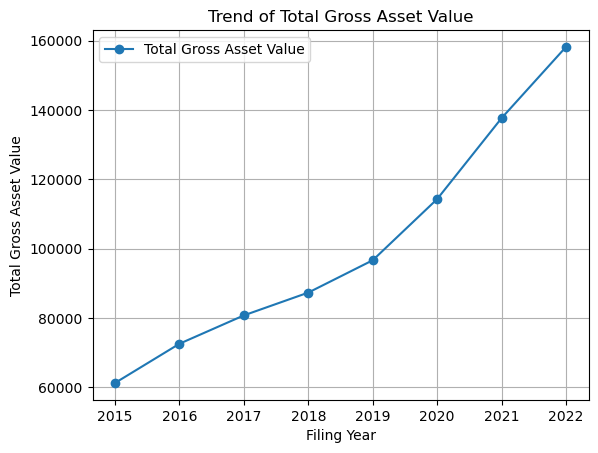

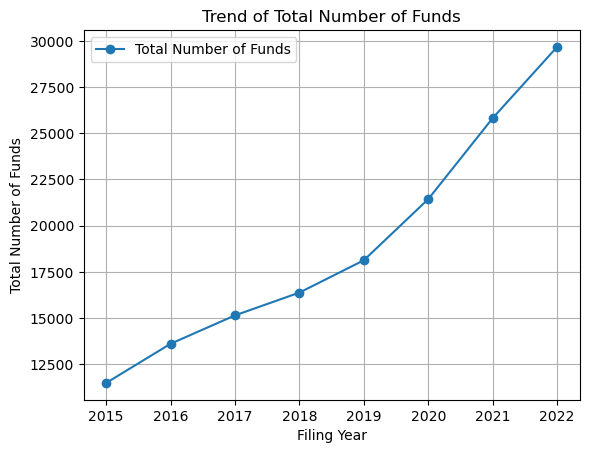

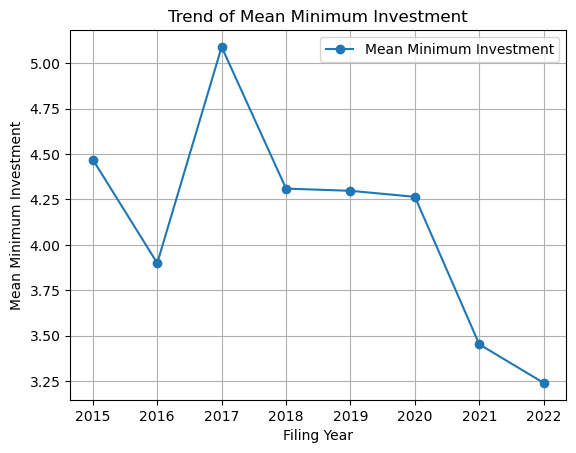

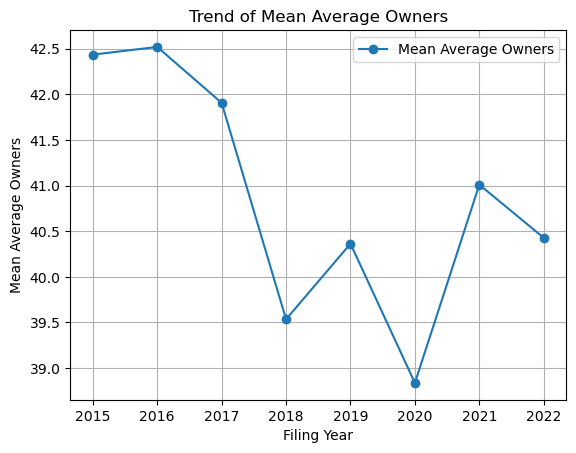

In [10]:
# QUESTION 2
pe.plot_adv_aggregate_timeseries(agg_adv)

In [11]:
"""
Part 2: Form D data

"""
formd = pe.load_formd_data()
formd

/var/folders/9k/6cxzhzks2dz55thdfdgpdj2w0000gn/T/ipykernel_7353/1754434185.py:119: DtypeWarning: Columns (5,6,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datasets/form_d/formD_masterfile_09Q1_23Q4.csv", parse_dates=['filing_date'])


,accessionnumber,qtr_form_d,file_num,filing_date,submissiontype,cik,stateorcountry,entitytype,yearofinc_value_entered,industrygrouptype,...,minimuminvestmentaccepted,over100recipientflag,totalofferingamount,totalamountsold,totalremaining,hasnonaccreditedinvestors,numbernonaccreditedinvestors,totalnumberalreadyinvested,grossproceedsused_dollaramount,grossproceedsused_isestimate
0,0000919574-09-008068,2009Q1,021-129337,2009-03-31,D,1460252.0,CT,Limited Partnership,2008.0,Pooled Investment Fund,...,1000000.0,NaN,Indefinite,670807,Indefinite,False,NaN,1.0,0.0,True
1,0001415725-09-000004,2009Q1,021-110008,2009-03-31,D,1415725.0,RI,Corporation,2007.0,Biotechnology,...,0.0,NaN,2774660,2774660,0,False,NaN,3.0,0.0,NaN
2,0001460194-09-000001,2009Q1,021-129332,2009-03-31,D,1460194.0,NY,Limited Liability Company,2006.0,Other,...,20000.0,NaN,2582500,2582500,0,False,NaN,25.0,250000.0,NaN
4,0001169232-09-001783,2009Q1,021-127207,2009-03-31,D,1457201.0,NY,Corporation,2005.0,Other,...,150000.0,NaN,10500000,700858,9799142,False,NaN,9.0,0.0,NaN
5,0001363176-09-000004,2009Q1,021-89848,2009-03-31,D,1363176.0,CA,Corporation,2006.0,Other Technology,...,0.0,NaN,8000035,7000035,1000000,False,NaN,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618934,0001969271-23-000003,2023Q4,021-476458,2023-10-02,D/A,1969271.0,TX,Limited Partnership,2022.0,Pooled Investment Fund,...,0.0,NaN,Indefinite,0,Indefinite,False,NaN,0.0,0.0,True
618935,0001865398-23-000001,2023Q4,021-493511,2023-10-02,D,1865398.0,DE,Corporation,2021.0,Other,...,0.0,NaN,4000000,710000,3290000,False,NaN,5.0,0.0,NaN
618936,0001994924-23-000001,2023Q4,021-493513,2023-10-02,D,1994924.0,CA,Limited Liability Company,2023.0,Residential,...,50000.0,NaN,2100000,2021299,78701,False,NaN,24.0,85000.0,NaN
618937,0001995604-23-000001,2023Q4,021-493508,2023-10-02,D,1995604.0,UT,Limited Liability Company,2023.0,Commercial,...,10000.0,NaN,2685001,2685001,0,False,NaN,37.0,0.0,NaN


In [12]:

formd = pe.filter_and_construct_formd_vars(formd)
formd

,accessionnumber,qtr_form_d,file_num,filing_date,submissiontype,cik,stateorcountry,entitytype,yearofinc_value_entered,industrygrouptype,...,totalofferingamount,totalamountsold,totalremaining,hasnonaccreditedinvestors,numbernonaccreditedinvestors,totalnumberalreadyinvested,grossproceedsused_dollaramount,grossproceedsused_isestimate,hasNonAccredited,vintage_year
0,0000071633-18-000039,2018Q4,021-327471,2018-12-10,D,71633.0,NY,Other,NaN,Insurance,...,0.000,22.325000,Indefinite,False,NaN,1.0,0.0,NaN,0,2018
1,0001567619-19-017162,2019Q3,021-346762,2019-08-16,D,353905.0,OH,Other,2019.0,Pooled Investment Fund,...,0.000,286.816946,Indefinite,False,NaN,0.0,0.0,NaN,0,2019
2,0001566114-15-000069,2015Q4,021-252366,2015-12-03,D,705318.0,OH,Other,NaN,Pooled Investment Fund,...,0.000,10.000000,Indefinite,False,NaN,1.0,0.0,NaN,0,2015
3,0000708563-10-000003,2010Q2,021-140724,2010-04-16,D,708563.0,PA,Limited Partnership,NaN,Pooled Investment Fund,...,10.000,0.140000,9900000,False,NaN,1.0,0.0,NaN,0,2010
4,0000708740-10-000003,2010Q4,021-150291,2010-11-10,D,708740.0,PA,Limited Partnership,NaN,Pooled Investment Fund,...,10.000,2.316061,10000000,False,NaN,0.0,0.0,NaN,0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118275,0002006437-23-000001,2023Q4,021-501220,2023-12-29,D,2006437.0,NY,Limited Liability Company,2023.0,Pooled Investment Fund,...,0.000,4.000000,Indefinite,False,NaN,5.0,0.0,NaN,0,2023
118276,0002006460-23-000001,2023Q4,021-501127,2023-12-29,D,2006460.0,TX,Limited Liability Company,2023.0,Pooled Investment Fund,...,0.000,1.042500,Indefinite,False,NaN,24.0,0.0,NaN,0,2023
118277,0002006523-23-000001,2023Q4,021-501190,2023-12-29,D,2006523.0,CO,Limited Liability Company,2018.0,Pooled Investment Fund,...,0.025,0.025000,0,False,NaN,3.0,0.0,NaN,0,2023
118278,0002006526-23-000001,2023Q4,021-501197,2023-12-29,D,2006526.0,IL,Limited Liability Company,2023.0,Pooled Investment Fund,...,0.273,0.273000,0,False,NaN,27.0,0.0,NaN,0,2023


In [13]:

agg_formd = pe.aggregate_formd(formd)
agg_formd

/var/folders/9k/6cxzhzks2dz55thdfdgpdj2w0000gn/T/ipykernel_7353/1754434185.py:208: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg['pct_amount_NonAccredited'] = df.groupby('vintage_year').apply(pct_non_accredited)


,Number_of_funds,Amount_raised,pct_NonAccredited,pct_amount_NonAccredited
vintage_year,,,,
2009,5437,2.210372e+06,8.920360,5.769883
2010,5119,2.783972e+06,5.743309,2.274708
2011,3412,7.028695e+05,3.253224,1.680726
2012,3497,6.293101e+05,3.660280,1.659950
2013,3998,9.116025e+05,2.301151,0.779919
2014,4945,7.052321e+05,2.345804,1.953043
2015,5245,8.835794e+05,1.258341,0.704775
2016,5400,8.801063e+05,1.129630,0.156039
2017,6057,9.083964e+05,1.188707,0.378959


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


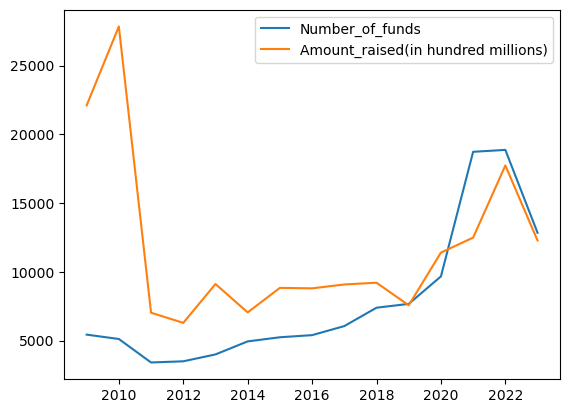

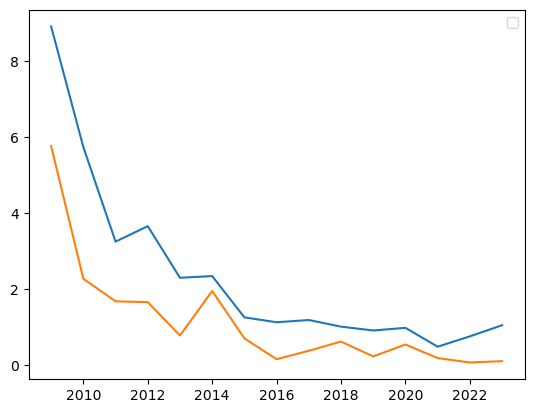

In [14]:


# QUESTION 3
pe.plot_formD(agg_formd)

In [19]:
"""
Part 3: PE Data

"""
gp = pe.load_preqin_gp_data()
manager = pe.load_preqin_manager_data()
sp500 = pe.load_sp500_data()
cf = pe.load_preqin_cf_data()

/var/folders/9k/6cxzhzks2dz55thdfdgpdj2w0000gn/T/ipykernel_7353/1754434185.py:243: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  manager = pd.read_csv("datasets/preqin/preqin_manager.csv")


In [20]:
cf.head()

,firm_id,fund_id,transaction_amount,transaction_date,transaction_type
0,152327,3,-13828.54,2000-02-14,Capital Call
1,152327,3,28595.60,2000-02-14,Distribution
2,152327,3,6300822.41,2000-03-31,Value
3,152327,3,86105.41,2000-05-15,Distribution
4,152327,3,6266071.73,2000-06-30,Value


In [21]:
gp.head()

,firm_id,fund_id,vintage,fund_type
0,152327,2,1989.0,Buyout
1,152327,3,1993.0,Buyout
2,152327,4,1998.0,Buyout
3,741,7,1995.0,Buyout
4,741,8,1998.0,Buyout


In [22]:
sp500.head()

,spindx,month,year
0,1394.46,1,2000
1,1366.42,2,2000
2,1498.58,3,2000
3,1452.43,4,2000
4,1420.60,5,2000


In [23]:
manager.head()

,firm_id,firmtype,firmcountry
6,53,Private Equity Firm,US
8,11,Private Equity Firm,US
9,12,Private Equity Firm,US
12,17,Private Equity Firm,US
15,21,Private Equity Firm,US


In [48]:
# Merge manager data with cf data
merged = pd.merge(manager, cf, on='firm_id', how='left')
merged.head()

,firm_id,firmtype,firmcountry,fund_id,transaction_amount,transaction_date,transaction_type
0,53,Private Equity Firm,US,NaN,NaN,NaN,NaN
1,11,Private Equity Firm,US,5365.0,-1432618.0,2005-08-15,Capital Call
2,11,Private Equity Firm,US,5365.0,1269954.0,2005-09-30,Value
3,11,Private Equity Firm,US,5365.0,-204800.0,2005-11-15,Capital Call
4,11,Private Equity Firm,US,5365.0,1425184.0,2005-12-31,Value


In [49]:
# Reshape the data using pivot_table to have a column for each transaction type
merged = merged.pivot_table(
    index=['firm_id', 'fund_id', 'transaction_date'], 
    columns='transaction_type', 
    values='transaction_amount', 
    aggfunc='sum',
    fill_value=0
)
merged = merged.reset_index()
merged

transaction_type,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value
0,11,5365.0,2005-08-15,-1432618.00,0.00,0.00
1,11,5365.0,2005-09-30,0.00,0.00,1269954.00
2,11,5365.0,2005-11-15,-204800.00,0.00,0.00
3,11,5365.0,2005-12-31,0.00,0.00,1425184.00
4,11,5365.0,2006-02-14,-850572.00,0.00,0.00
...,...,...,...,...,...,...
87701,504345,131656.0,2022-02-14,-1009477.00,23462.34,0.00
87702,504345,131656.0,2022-03-31,0.00,0.00,856159.50
87703,504345,131656.0,2022-06-30,0.00,0.00,795167.83
87704,504345,131656.0,2022-08-15,-965465.17,0.00,0.00


In [50]:
# Prepare S&P 500 data by creating a 'yyyymm' column for easier merging
sp500['yyyymm'] = sp500['year'].astype(str) + sp500['month'].astype(str).str.zfill(2)
sp500

,spindx,month,year,yyyymm
0,1394.46,1,2000,200001
1,1366.42,2,2000,200002
2,1498.58,3,2000,200003
3,1452.43,4,2000,200004
4,1420.60,5,2000,200005
...,...,...,...,...
283,4507.66,8,2023,202308
284,4288.05,9,2023,202309
285,4193.80,10,2023,202310
286,4567.80,11,2023,202311


In [51]:
# Add 'yyyymm' to merged data for S&P 500 merging
merged['yyyymm'] = merged['transaction_date'].str.replace('-', '').str[:6]
merged.head()

transaction_type,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,yyyymm
0,11,5365.0,2005-08-15,-1432618.0,0.0,0.0,200508
1,11,5365.0,2005-09-30,0.0,0.0,1269954.0,200509
2,11,5365.0,2005-11-15,-204800.0,0.0,0.0,200511
3,11,5365.0,2005-12-31,0.0,0.0,1425184.0,200512
4,11,5365.0,2006-02-14,-850572.0,0.0,0.0,200602


In [55]:
merged = pe.process_data(gp, manager, sp500, cf)
merged
merged = merged.sort_values(by=['fund_id', 'yyyymm', 'firm_id'])
merged

,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,yyyymm,spindx,vintage,fund_type,age
2118,44,158.0,2002-02-14,193792.0,0.00,0.0,200202,1106.73,2002.0,Buyout,0.0
2119,44,158.0,2002-03-31,0.0,0.00,183348.0,200203,1147.39,2002.0,Buyout,0.0
2120,44,158.0,2002-06-30,0.0,0.00,186348.0,200206,989.81,2002.0,Buyout,0.0
2121,44,158.0,2002-09-30,869231.0,0.00,0.0,200209,815.29,2002.0,Buyout,0.0
2122,44,158.0,2002-12-31,0.0,0.00,960962.0,200212,879.82,2002.0,Buyout,0.0
...,...,...,...,...,...,...,...,...,...,...,...
84355,138612,52990.0,2015-06-30,0.0,0.00,2024323.4,201506,2063.11,2014.0,Buyout,1.0
84356,138612,52990.0,2015-08-15,184895.8,184895.71,0.0,201508,1972.18,2014.0,Buyout,1.0
84357,138612,52990.0,2015-09-30,0.0,0.00,2155230.0,201509,1920.03,2014.0,Buyout,1.0
84358,138612,52990.0,2015-11-15,893499.1,34164.00,0.0,201511,2080.41,2014.0,Buyout,1.0


In [56]:
merged['sp500_t0'] = merged.groupby(['fund_id'])['spindx'].transform('first')
merged

,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,yyyymm,spindx,vintage,fund_type,age,sp500_t0
2118,44,158.0,2002-02-14,193792.0,0.00,0.0,200202,1106.73,2002.0,Buyout,0.0,1106.73
2119,44,158.0,2002-03-31,0.0,0.00,183348.0,200203,1147.39,2002.0,Buyout,0.0,1106.73
2120,44,158.0,2002-06-30,0.0,0.00,186348.0,200206,989.81,2002.0,Buyout,0.0,1106.73
2121,44,158.0,2002-09-30,869231.0,0.00,0.0,200209,815.29,2002.0,Buyout,0.0,1106.73
2122,44,158.0,2002-12-31,0.0,0.00,960962.0,200212,879.82,2002.0,Buyout,0.0,1106.73
...,...,...,...,...,...,...,...,...,...,...,...,...
84355,138612,52990.0,2015-06-30,0.0,0.00,2024323.4,201506,2063.11,2014.0,Buyout,1.0,2067.56
84356,138612,52990.0,2015-08-15,184895.8,184895.71,0.0,201508,1972.18,2014.0,Buyout,1.0,2067.56
84357,138612,52990.0,2015-09-30,0.0,0.00,2155230.0,201509,1920.03,2014.0,Buyout,1.0,2067.56
84358,138612,52990.0,2015-11-15,893499.1,34164.00,0.0,201511,2080.41,2014.0,Buyout,1.0,2067.56


In [57]:

merged['discountcall'] = merged['Capital Call'] / merged['spindx'] * merged['sp500_t0']
# 14. For the end of the fund’s life, we will treat the last valuation in that year
#       as a distribution. So, the final “distribution” is the valuation plus the actual
#       distribution.
lastindex = merged[merged['Value'] != 0].drop_duplicates(subset=['firm_id', 'fund_id'], keep = 'last').index
merged.loc[lastindex, 'Distribution'] = merged.loc[lastindex, 'Distribution'] + merged.loc[lastindex, 'Value']
# 15. Using the formulas in the readings, construct the KS-PME.  You will need to sum up
#       the discounted capital calls and distributions at the fund level and then take a
#       ratio.  The end result is a PME for each fundid that is matched to its vintage year.
merged['discountdistribution'] = merged['Distribution'] / merged['spindx'] * merged['sp500_t0']
merged

,firm_id,fund_id,transaction_date,Capital Call,Distribution,Value,yyyymm,spindx,vintage,fund_type,age,sp500_t0,discountcall,discountdistribution
2118,44,158.0,2002-02-14,193792.0,0.00,0.0,200202,1106.73,2002.0,Buyout,0.0,1106.73,1.937920e+05,0.000000e+00
2119,44,158.0,2002-03-31,0.0,0.00,183348.0,200203,1147.39,2002.0,Buyout,0.0,1106.73,0.000000e+00,0.000000e+00
2120,44,158.0,2002-06-30,0.0,0.00,186348.0,200206,989.81,2002.0,Buyout,0.0,1106.73,0.000000e+00,0.000000e+00
2121,44,158.0,2002-09-30,869231.0,0.00,0.0,200209,815.29,2002.0,Buyout,0.0,1106.73,1.179953e+06,0.000000e+00
2122,44,158.0,2002-12-31,0.0,0.00,960962.0,200212,879.82,2002.0,Buyout,0.0,1106.73,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84355,138612,52990.0,2015-06-30,0.0,0.00,2024323.4,201506,2063.11,2014.0,Buyout,1.0,2067.56,0.000000e+00,0.000000e+00
84356,138612,52990.0,2015-08-15,184895.8,184895.71,0.0,201508,1972.18,2014.0,Buyout,1.0,2067.56,1.938379e+05,1.938378e+05
84357,138612,52990.0,2015-09-30,0.0,0.00,2155230.0,201509,1920.03,2014.0,Buyout,1.0,2067.56,0.000000e+00,0.000000e+00
84358,138612,52990.0,2015-11-15,893499.1,34164.00,0.0,201511,2080.41,2014.0,Buyout,1.0,2067.56,8.879803e+05,3.395298e+04


In [58]:
df = merged.groupby(['fund_id', 'vintage'])[['discountdistribution', 'discountcall']]\
    .apply(lambda x: x['discountdistribution'].sum() / x['discountcall'].sum()).reset_index(name='KS-PME')
df

,fund_id,vintage,KS-PME
0,158.0,2002.0,1.090317
1,209.0,2002.0,1.521110
2,226.0,2000.0,1.295715
3,293.0,2000.0,1.257998
4,297.0,2000.0,1.526893
...,...,...,...
328,47157.0,2014.0,1.671616
329,48981.0,2014.0,1.008098
330,49087.0,2014.0,0.731479
331,50925.0,2014.0,0.011492


In [59]:
merged = pe.create_variables(merged)
merged

/var/folders/9k/6cxzhzks2dz55thdfdgpdj2w0000gn/T/ipykernel_7353/1754434185.py:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = merged.groupby(['fund_id', 'vintage']).apply(


,fund_id,vintage,KS-PME
0,158.0,2002.0,1.848371
1,209.0,2002.0,1.594105
2,226.0,2000.0,1.356639
3,293.0,2000.0,1.528515
4,297.0,2000.0,2.111744
...,...,...,...
328,47157.0,2014.0,1.901841
329,48981.0,2014.0,2.007721
330,49087.0,2014.0,1.462958
331,50925.0,2014.0,0.022984


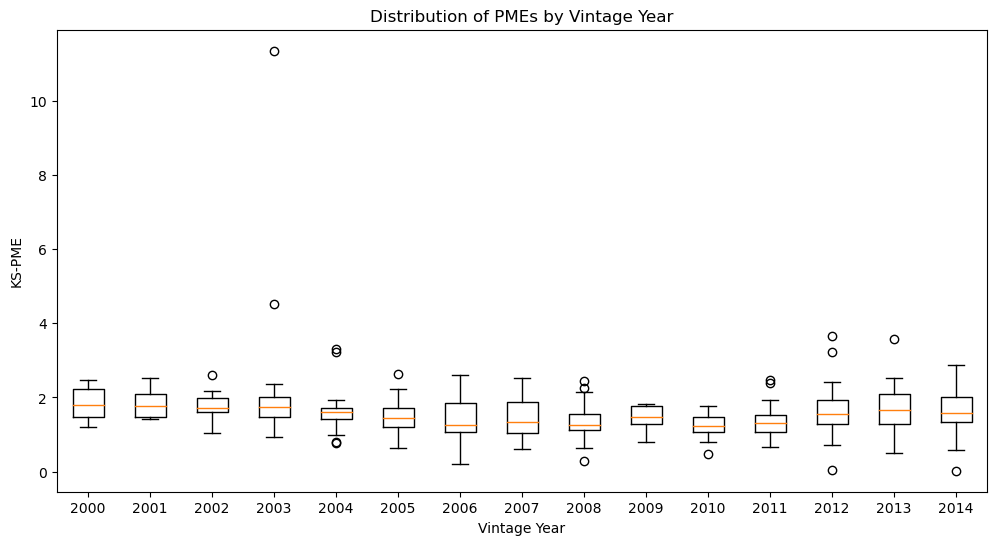

In [60]:
# QUESTION 4
pe.pme_box_plot(merged)

ts = pe.create_agg_time_series(merged)

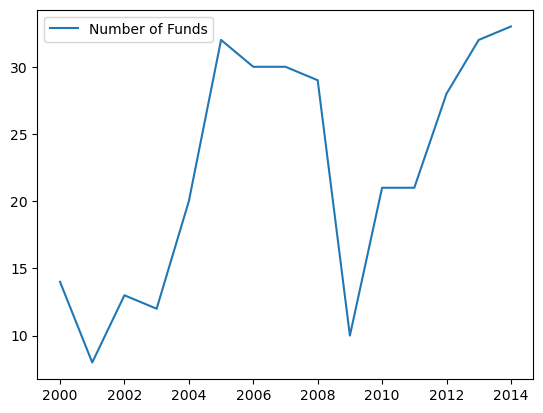

In [61]:
# QUESTION 5
pe.plot_pme_time_series(ts)

